# Generative Adversarial Network

In [1]:
import time
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook use [%s]."%(device))

PyTorch version:[1.6.0].
This notebook use [cuda:0].


### Define GAN

In [2]:
class Generator(nn.Module):
    def __init__(self, img_dim=[1,28,28], z_dim=16, gf_dim=64):
        super(Generator, self).__init__() 
        self.img_dim = img_dim
        self.z_dim = z_dim
        self.gf_dim = gf_dim
        self.s, self.s4, self.s8 = img_dim[-1], img_dim[-1]//4, img_dim[-1]//8
        
        self.linear = nn.Linear(z_dim, gf_dim*self.s8*self.s8)
        self.bn1 = nn.BatchNorm2d(gf_dim)

        self.deconv1 = nn.ConvTranspose2d(gf_dim, gf_dim//2, 5, 1, 0)
        self.bn2 = nn.BatchNorm2d(gf_dim//2)
        
        self.deconv2 = nn.ConvTranspose2d(gf_dim//2, gf_dim//4, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(gf_dim//4)
        
        self.deconv3 = nn.ConvTranspose2d(gf_dim//4, 1, 4, 2, 1)
        
                    
    def forward(self, X):
        X = self.linear(X)
        X = self.bn1(X.reshape(-1, self.gf_dim, self.s8, self.s8))
        X = torch.relu(self.bn2(self.deconv1(X)))
        X = torch.relu(self.bn3(self.deconv2(X)))
        X = torch.sigmoid(self.deconv3(X))
        return X

class Discriminator(nn.Module):
    def __init__(self, img_dim=[1,28,28], df_dim=64):

        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(img_dim[0], df_dim//4, 5, 2, 2)
        
        self.conv2 = nn.Conv2d(df_dim//4, df_dim//2, 5, 2, 2)
        
        self.conv3 = nn.Conv2d(df_dim//2, df_dim, 5, 2, 2)
        
        pooled_size = (img_dim[-1]//8) + 1
        self.dense = nn.Linear(df_dim*pooled_size*pooled_size, 1)

    def forward(self, X):
        X = F.leaky_relu(self.conv1(X))
        X = F.leaky_relu(self.conv2(X))
        X = F.leaky_relu(self.conv3(X))
        X = X.reshape(X.size(0), -1)
        X = torch.sigmoid(self.dense(X))
        return X

In [3]:
class GenerativeAdversarialNetworkClass(object):
    """
    Generative Adversarial Network
    """
    def __init__(self,name='gan',img_dim=[1,28,28],z_dim=16,batch_size=32,
                 gf_dim=64,df_dim=64,device=None):
        """
        Initialize
        """

        self.name = name
        self.img_dim = img_dim
        self.z_dim = z_dim
        self.batch_size = batch_size
        self.gf_dim = gf_dim # G final conv feature dim
        self.df_dim = df_dim # D final conv feature dim
        self.device = device

        self.build_model()
        
    def build_model(self):
        """
        Build model
        """
        
        self.g = Generator(img_dim=self.img_dim, z_dim=self.z_dim, gf_dim=self.gf_dim).to(self.device)

        self.d = Discriminator(img_dim=self.img_dim, df_dim=self.df_dim).to(self.device)
        
        self.cost = nn.BCELoss()
        self.d_optim = torch.optim.Adam(self.d.parameters(), lr=0.0002)
        self.g_optim = torch.optim.Adam(self.g.parameters(), lr=0.0002)
        
    def update(self, x_batch, z_batch):
        """
        Update model 
        """
        real_lab = torch.ones((x_batch.size(0), 1)).to(device)
        fake_lab = torch.zeros((x_batch.size(0), 1)).to(device)
        
         # Training Discriminator
        D_pred = self.d.forward(x_batch)
        # print(D_pred.shape)
        d_loss_real = self.cost(D_pred, real_lab)
        real_score = D_pred
        
        fake_images = self.g.forward(z_batch)
        G_pred = self.d.forward(fake_images)
        d_loss_fake = self.cost(G_pred, fake_lab)
        fake_score = G_pred
        
        d_loss = d_loss_real + d_loss_fake
        self.g_optim.zero_grad()
        self.d_optim.zero_grad()
        d_loss.backward()
        self.d_optim.step()

        # Training Generator
        fake_images = self.g.forward(z_batch)
        G_pred = self.d.forward(fake_images)
        
        g_loss = self.cost(G_pred, real_lab)
        
        self.g_optim.zero_grad()
        g_loss.backward()
        self.g_optim.step()

        return g_loss, d_loss
        
print ("Ready.")

Ready.


### Training data

In [4]:
train_dataset = datasets.MNIST('../data/mnist_data/',
                             download=True,
                             train=True) 
x = train_dataset.data.unsqueeze(1)/255.
n = len(x)

print ("n_train:[%d], x_dim:[%s]"%
       (n,x.shape))

n_train:[60000], x_dim:[torch.Size([60000, 1, 28, 28])]


### Instantiate GAN

In [5]:
G = GenerativeAdversarialNetworkClass(
    name='gan',img_dim=[1, 28, 28],z_dim=16,gf_dim=64,df_dim=64,device=device)
print ("[%s] instantiated."%(G.name))

[gan] instantiated.


### Merge images into an image

In [6]:
def merge_imgs(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 1))
    for idx, image in enumerate(images):
        image = image.reshape(28, 28)
        i = idx % size[1]
        j = idx // size[1]        
        img[j*h:j*h+h, i*w:i*w+w, 0] = image
    return img

### Loop

[0/30] g_loss:[5.164] d_loss:[0.086].


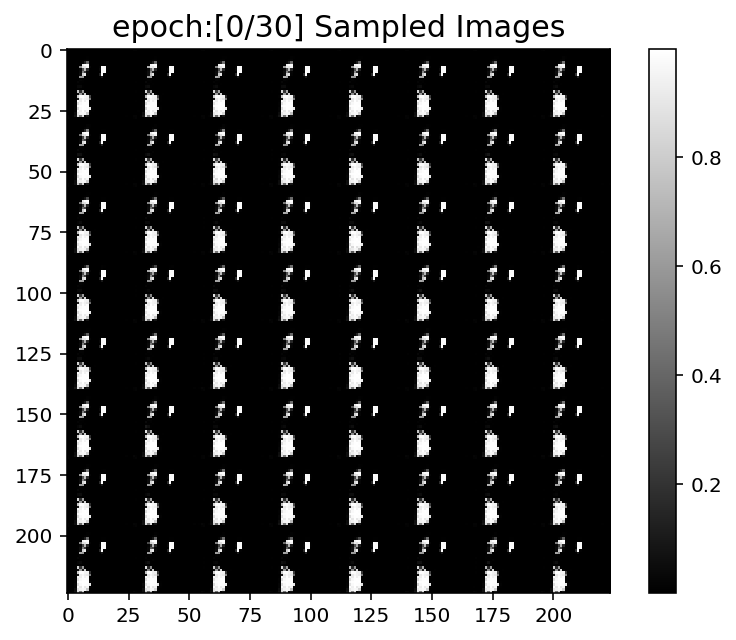

[1/30] g_loss:[4.407] d_loss:[0.140].
[2/30] g_loss:[4.003] d_loss:[0.172].
[3/30] g_loss:[2.871] d_loss:[0.431].
[4/30] g_loss:[1.782] d_loss:[0.781].
[5/30] g_loss:[1.437] d_loss:[0.916].


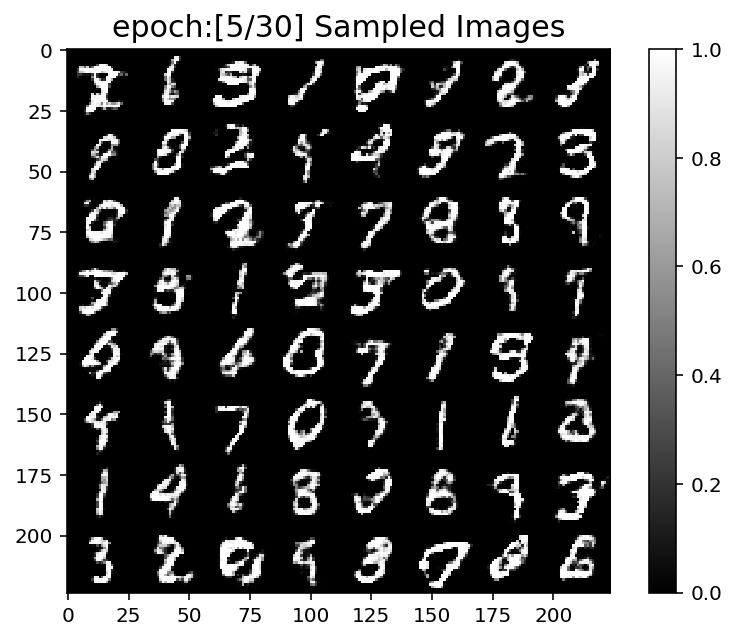

[6/30] g_loss:[1.331] d_loss:[0.992].
[7/30] g_loss:[1.299] d_loss:[1.004].
[8/30] g_loss:[1.296] d_loss:[0.996].
[9/30] g_loss:[1.308] d_loss:[0.988].
[10/30] g_loss:[1.328] d_loss:[0.968].


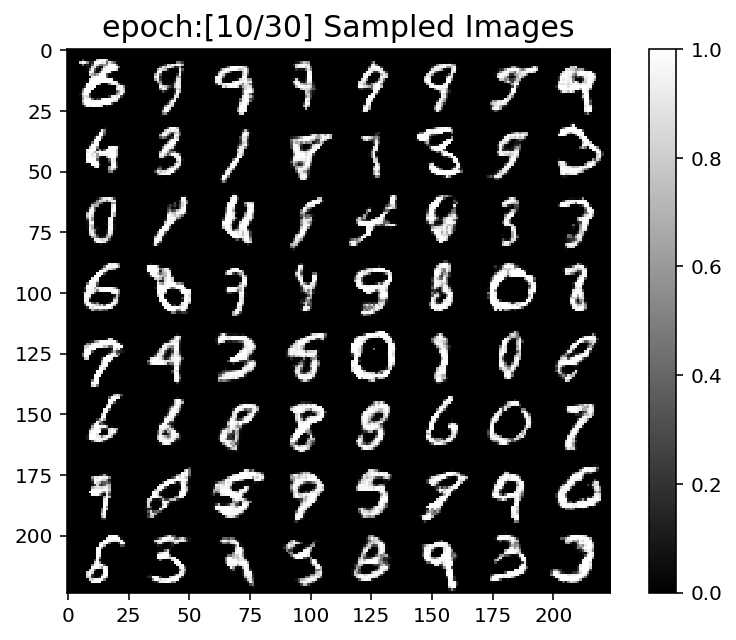

[11/30] g_loss:[1.349] d_loss:[0.952].
[12/30] g_loss:[1.370] d_loss:[0.944].
[13/30] g_loss:[1.399] d_loss:[0.925].
[14/30] g_loss:[1.442] d_loss:[0.905].
[15/30] g_loss:[1.467] d_loss:[0.894].


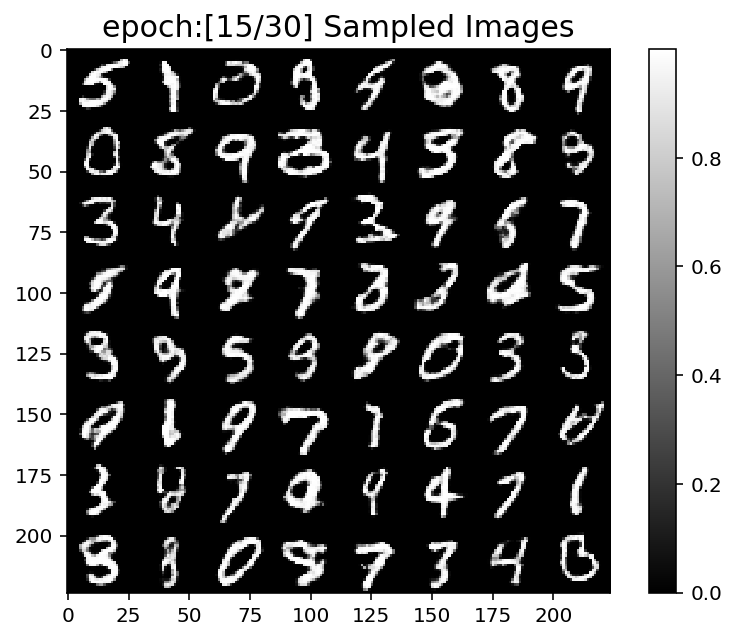

[16/30] g_loss:[1.505] d_loss:[0.879].
[17/30] g_loss:[1.538] d_loss:[0.859].
[18/30] g_loss:[1.572] d_loss:[0.849].
[19/30] g_loss:[1.609] d_loss:[0.831].
[20/30] g_loss:[1.646] d_loss:[0.815].


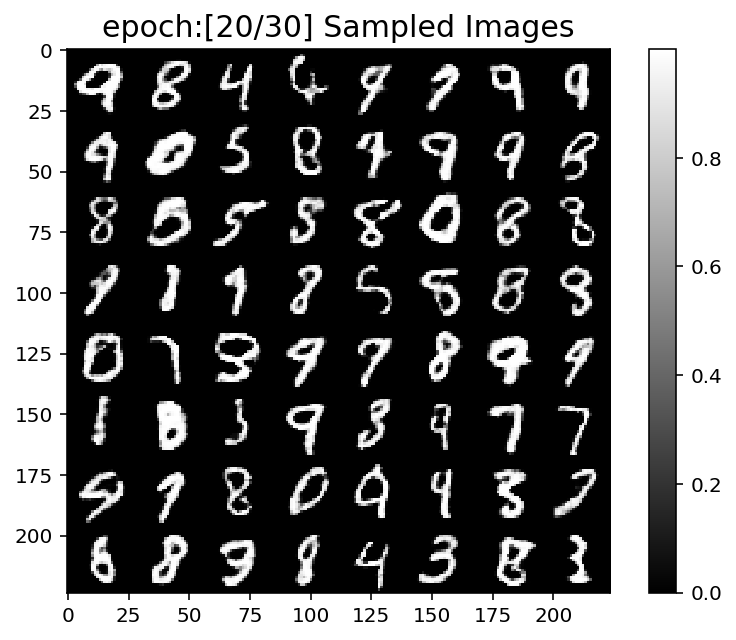

[21/30] g_loss:[1.680] d_loss:[0.806].
[22/30] g_loss:[1.706] d_loss:[0.793].
[23/30] g_loss:[1.741] d_loss:[0.779].
[24/30] g_loss:[1.785] d_loss:[0.765].
[25/30] g_loss:[1.800] d_loss:[0.753].


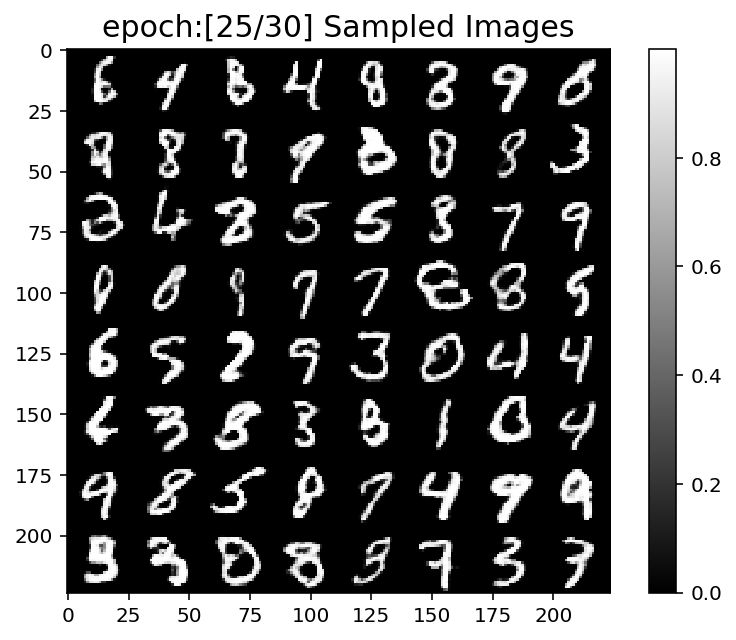

[26/30] g_loss:[1.824] d_loss:[0.744].
[27/30] g_loss:[1.850] d_loss:[0.730].
[28/30] g_loss:[1.888] d_loss:[0.719].
[29/30] g_loss:[1.907] d_loss:[0.707].


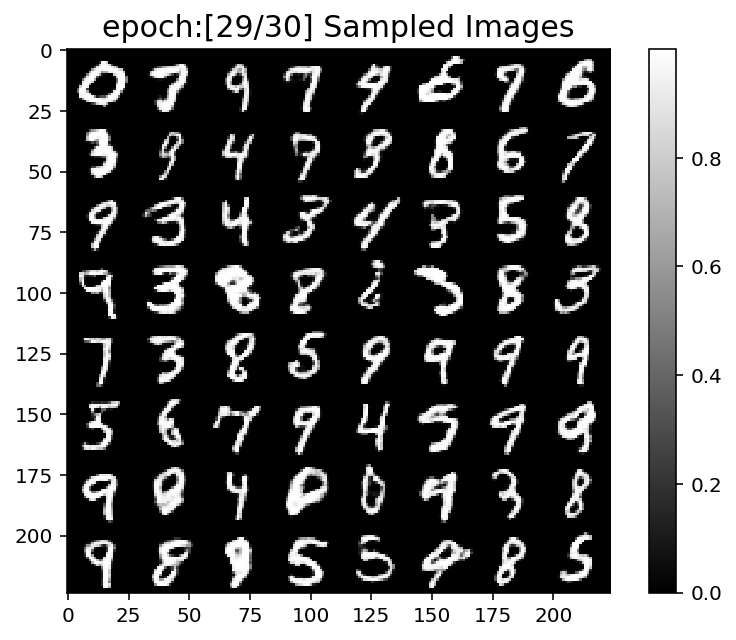

Done.


In [7]:
sample_size,sample_grid = 64,[8,8]
z_sample = np.random.uniform(-1, 1, size=(sample_size, G.z_dim))

start_time = time.time() 
max_epoch,batch_size,print_every,plot_every = 30,33,1,5
for epoch in range(int(max_epoch)):
    
    r_idx = np.random.permutation(n)
    max_iter = np.ceil(n/batch_size).astype(np.int) # number of iterations
    g_loss_val_sum,d_loss_val_sum = 0,0
    for it in range(max_iter):
        
        b_idx = r_idx[batch_size*(it):batch_size*(it+1)]
        x_batch = x[b_idx,:].to(device)
        z_batch = torch.normal(0, 1, (len(b_idx), G.z_dim)).to(device)
        
        # Update
        g_loss_val,d_loss_val = G.update(x_batch,z_batch)
        g_loss_val_sum += g_loss_val
        d_loss_val_sum += d_loss_val
    g_loss_val_avg,d_loss_val_avg = g_loss_val_sum/max_iter,d_loss_val_sum/max_iter
    
    # Print
    if ((epoch%print_every)==0) or (epoch==(max_epoch-1)):
        print ("[%d/%d] g_loss:[%.3f] d_loss:[%.3f]."%
               (epoch,max_epoch,g_loss_val_avg,d_loss_val_avg))
    
    # Plot 
    if ((epoch%plot_every)==0) or (epoch==(max_epoch-1)):
        latent_z = torch.normal(0, 1, (sample_size, G.z_dim)).to(device)
        generated_imgs = G.g(latent_z).squeeze(1).cpu().detach().numpy()
        img_merged = merge_imgs(generated_imgs, sample_grid)
        plt.figure(figsize=(7,5))
        plt.imshow(img_merged[:,:,0],cmap='gray',interpolation='nearest',aspect='equal')
        plt.title('epoch:[%d/%d] Sampled Images'%(epoch,max_epoch),fontsize=15)
        plt.colorbar(); plt.show()
    
print ("Done.")